<a href="https://colab.research.google.com/github/omiano/english_language_learning/blob/master/english_language_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English Language Learning Kaggle Competition

The goal of this competition is to assess the language proficiency of 8th-12th grade English Language Learners (ELLs).

The dataset (the ELLIPSE corpus) comprises argumentative essays written by 8th-12th grade ELLs that have been scored according to six analytic measures: cohesion, syntax, vocabulary, phraseology, grammar, and conventions.

Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. The scores range from 1.0 to 5.0 in increments of 0.5. This notebook is tackling the task of predicting the score of each of the six measures for the essays given in the test set.

More information on the competition and datasets can be found [here](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview).

## Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.0 MB/s eta 0:00:00


In [ ]:
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModel, TrainingArguments, Trainer

## Data Overview

In [ ]:
train_df = pd.read_csv('train.csv')

In [ ]:
print('There are {} train samples'.format(train_df.shape[0]))

There are 3911 train samples


In [ ]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
train_df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Data Visualizations

### Target Variables Distributions

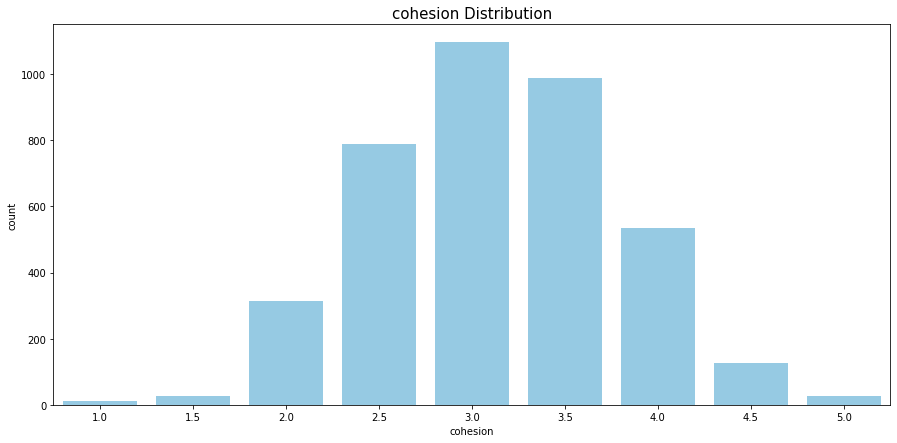

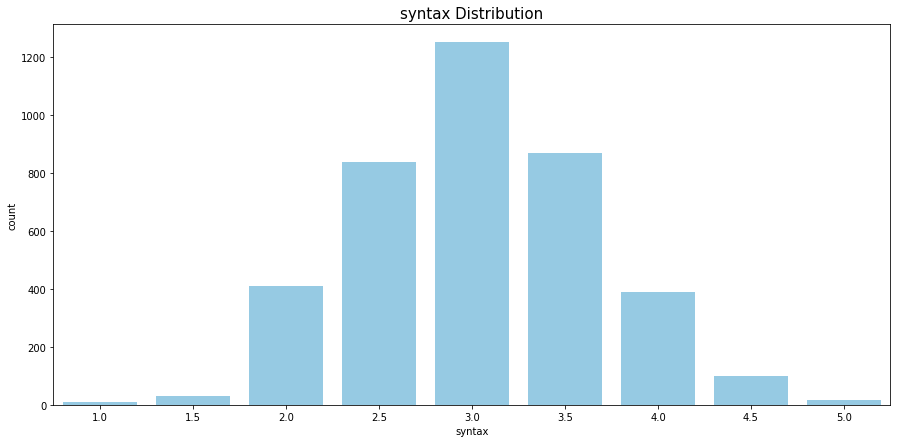

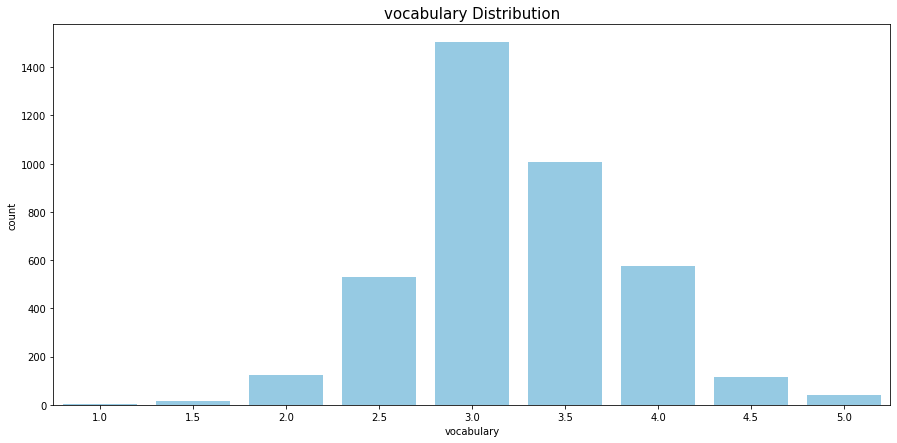

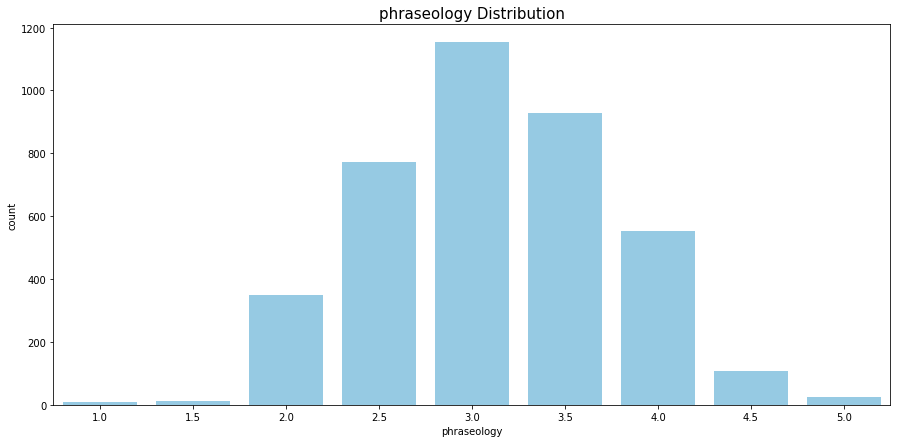

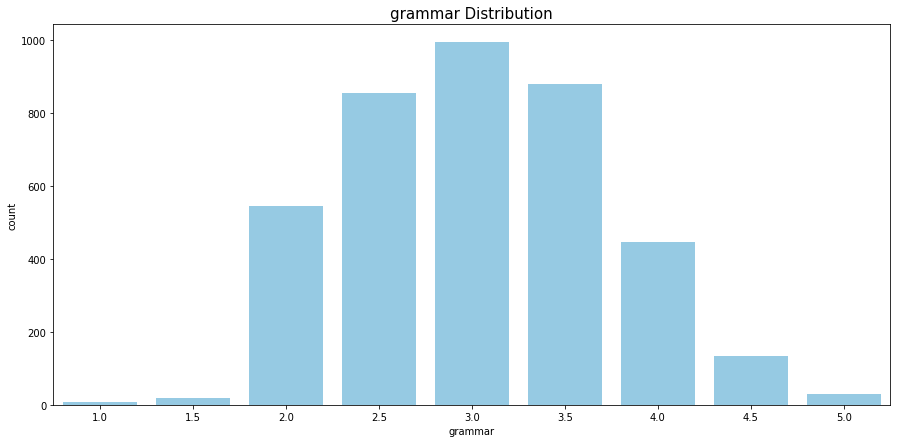

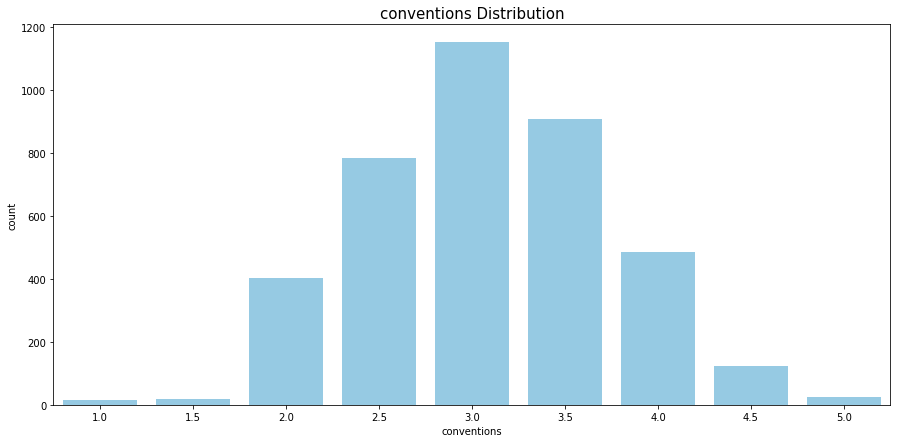

In [ ]:
features = train_df.select_dtypes('number').columns

for f in features:
    plt.figure(figsize = (15, 7))
      
    # Plot values
    sns.countplot(x=train_df[f], color='#89cff0')
    
    plt.title(f + ' Distribution', fontsize=15)
    plt.show()

### Text Features Distributions

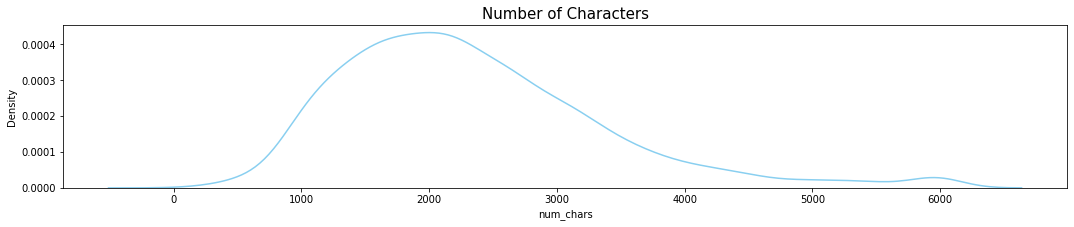

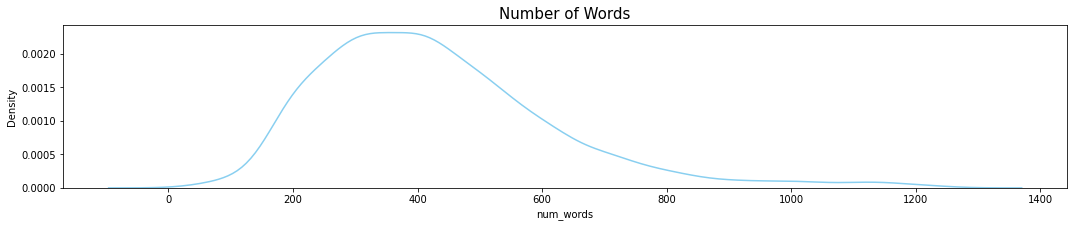

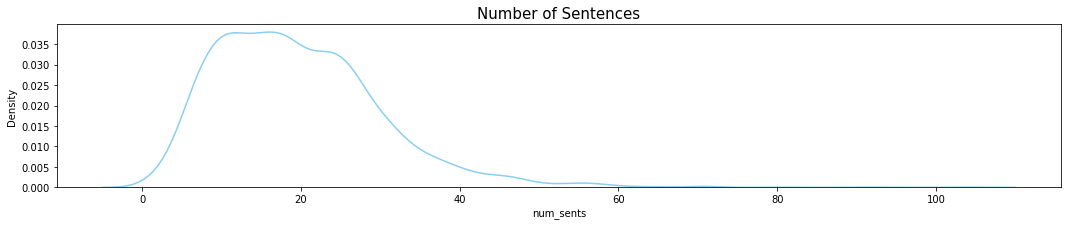

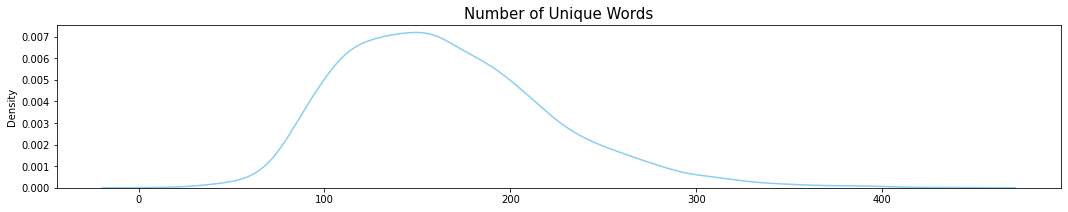

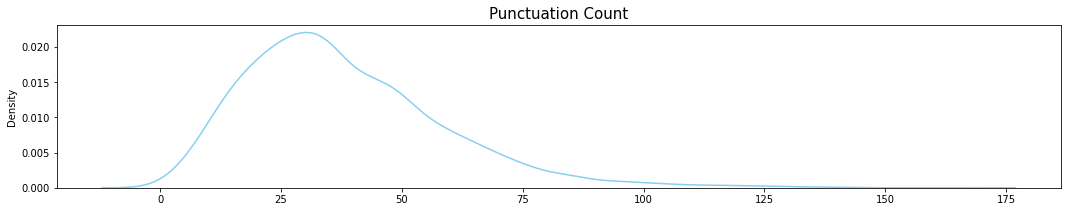

In [ ]:
# Plot number of characters
train_df['num_chars'] = train_df['full_text'].str.len()

plt.figure(figsize = (18, 3))
sns.kdeplot(train_df['num_chars'], color='#89cff0') 
plt.title('Number of Characters', fontsize=15)
plt.show()
      
# Plot number of words
train_df['num_words'] = train_df['full_text'].str.split().str.len()

plt.figure(figsize = (18, 3))
sns.kdeplot(train_df['num_words'], color='#89cff0')
plt.title('Number of Words', fontsize=15)
plt.show()

# Plot number of sentences
train_df['num_sents'] = train_df['full_text'].str.split('[?.!]').str.len()

plt.figure(figsize = (18, 3))
sns.kdeplot(train_df['num_sents'], color='#89cff0')
plt.title('Number of Sentences', fontsize=15)
plt.show()

# Plot number of unique words
train_unique_words = [len(Counter(txt.lower().split())) for txt in train_df['full_text']]
train_df['num_unique_words'] = train_unique_words

plt.figure(figsize = (18, 3))
sns.kdeplot(train_unique_words, color='#89cff0')
plt.title('Number of Unique Words', fontsize=15)
plt.show()

# Plot punctuation count
train_punct = [sum([1 for c in txt if c in ".,'!?;"]) for txt in train_df['full_text']]
train_df['num_punct'] = train_punct

plt.figure(figsize = (18, 3))
sns.kdeplot(train_punct, color='#89cff0')
plt.title('Punctuation Count', fontsize=15)
plt.show()

## Datasets, Dataloaders, and Preprocessing

In [ ]:
# Hyperparameters
DEVICE = 'cuda'
LEARNING_RATE = 2e-05
NUM_EPOCHS = 20
NUM_WORKERS = 2
MAX_LENGTH = 512
TEST_BATCH_SIZE = 32
TRAIN_BATCH_SIZE = 32
MODEL_NAME = 'distilbert-base-uncased'

In [ ]:
class EnglishLanguageLearningDataset(Dataset):
  def __init__(
      self,
      data
  ):
    self.data = data
    self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
  def __len__(self):
    return len(self.data)
    
  def __getitem__(
      self, 
      index: int
  ):
    data = self.tokenizer(
      self.data['full_text'].iloc[index],
      truncation=True,
      padding='max_length',
      max_length=MAX_LENGTH,
      return_tensors='pt'
      )
    input_ids, attention_mask = data.values()
    data = [input_ids, attention_mask]

    labels = torch.tensor(self.data[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].iloc[index])

    return data, labels

### Load and split dataset

In [ ]:
data = pd.read_csv('./train.csv')
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=777)
validation_data, test_data = train_test_split(validation_data, test_size=0.5, random_state=777)

train_dataset = EnglishLanguageLearningDataset(train_data)
validation_dataset = EnglishLanguageLearningDataset(validation_data)
test_dataset = EnglishLanguageLearningDataset(test_data)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=TRAIN_BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=NUM_WORKERS)

validation_loader = DataLoader(validation_dataset,
                               batch_size=TEST_BATCH_SIZE,
                               shuffle=False,
                               num_workers=NUM_WORKERS)

test_loader = DataLoader(test_dataset,
                         batch_size=TEST_BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

## Simple DistilBERT-based Multi-Task Learning Model

In [ ]:
class BERTModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.model = AutoModel.from_pretrained(MODEL_NAME)
    self.cohesion_linear = torch.nn.Linear(self.model.config.hidden_size, 9)
    self.syntax_linear = torch.nn.Linear(self.model.config.hidden_size, 9)
    self.vocabulary_linear = torch.nn.Linear(self.model.config.hidden_size, 9)
    self.phraseology_linear = torch.nn.Linear(self.model.config.hidden_size, 9)
    self.grammar_linear = torch.nn.Linear(self.model.config.hidden_size, 9)
    self.conventions_linear = torch.nn.Linear(self.model.config.hidden_size, 9)

  def mean_pooling(self, embeddings, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    return torch.sum(embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  def forward(self, inputs):
    input_ids, attention_mask = inputs
    input_ids = input_ids.squeeze(1)
    attention_mask = attention_mask.squeeze(1)
    outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
            output_hidden_states=True
        )
    outputs = self.mean_pooling(outputs['last_hidden_state'], attention_mask)

    cohesion = self.cohesion_linear(outputs)
    syntax = self.syntax_linear(outputs)
    vocabulary = self.vocabulary_linear(outputs)
    phraseology = self.phraseology_linear(outputs)
    grammar = self.grammar_linear(outputs)
    conventions = self.conventions_linear(outputs)
    
    return cohesion, syntax, vocabulary, phraseology, grammar, conventions

In [ ]:
model = BERTModel().to(DEVICE)
optimizer = torch.optim.AdamW(chain(model.parameters()), lr=LEARNING_RATE)
criterion = [torch.nn.CrossEntropyLoss() for _ in range(6)]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training

In [ ]:
def evaluate(data_loader):
  model.eval()
  all_predictions = []
  all_labels = [labels for _, labels in data_loader]

  with torch.no_grad():
    for data, labels in tqdm(data_loader, desc='Evaluating'):
      data = [d.to(DEVICE) for d in data]
      labels = labels.transpose(0, 1).type(torch.LongTensor).to(DEVICE)

      predictions = model(data)
      preds = torch.argmax(torch.stack(predictions), dim=-1)

      all_predictions.append(preds.transpose(0,1))

  all_predictions = torch.cat(all_predictions).transpose(0,1)
  all_labels = torch.cat(all_labels).transpose(0,1)

  losses = [c(pred, label) for c, pred, label in zip(criterion, predictions, labels)]
  loss = sum(losses)

  mcrmse = np.mean([np.sqrt(metrics.mean_squared_error(labels.cpu().numpy(), preds.cpu().numpy())) for labels, preds in zip(all_labels, all_predictions)])

  return mcrmse, loss, all_predictions

In [ ]:
def save_model(epoch, model, optimizer, criterion):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, './best_model.pth')

In [ ]:
training_loss, validation_loss, validation_mcrmse = [], [], []
loss, val_loss, mcrmse = torch.tensor(0), torch.tensor(0), 0
best_mcrmse = -1

for epoch in range(NUM_EPOCHS):
  model.train()
  pbar = tqdm(train_loader, desc='Epoch {}'.format(epoch))
  pbar.set_postfix({'train_loss': loss.item(), 'val_loss': val_loss.item(), 'val_mcrmse': mcrmse})

  for data, labels in pbar:
    data = [d.to(DEVICE) for d in data]
    labels = labels.transpose(0, 1).type(torch.LongTensor).to(DEVICE)

    optimizer.zero_grad()
    predicted_labels = model(data)
   
    # Simply summing losses for each target variable for now...
    losses = [c(pred, label) for c, pred, label in zip(criterion, predicted_labels, labels)]
    loss = sum(losses)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

  mcrmse, val_loss, _ = evaluate(validation_loader)

  training_loss.append(loss.item())
  validation_loss.append(val_loss.item())
  validation_mcrmse.append(mcrmse)

  if best_mcrmse == -1 or mcrmse < best_mcrmse:
    best_mcrmse = mcrmse
    save_model(epoch, model, optimizer, criterion)

Epoch 0:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/85 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

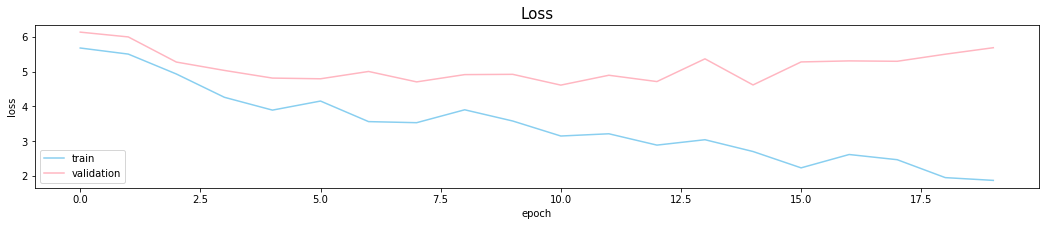

In [ ]:
# Plot train & validation loss
plt.figure(figsize = (18, 3))

sns.lineplot(data={'loss': training_loss, 'epoch': [i for i in range(NUM_EPOCHS)]}, x='epoch', y='loss', color='#89cff0', label='train')
sns.lineplot(data={'loss': validation_loss, 'epoch': [i for i in range(NUM_EPOCHS)]}, x='epoch', y='loss', color='#ffb6c1', label='validation')
    
plt.title('Loss', fontsize=15)
plt.legend()
plt.show()

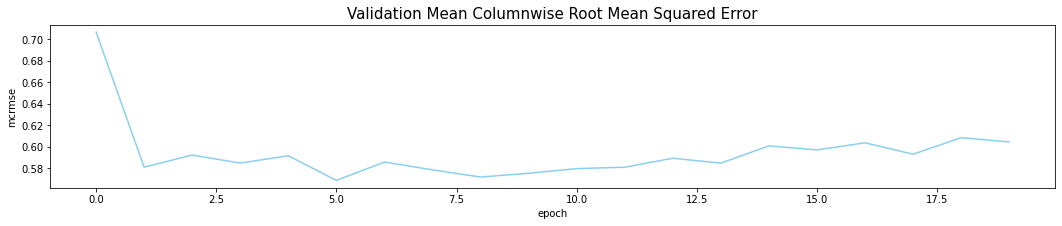

In [ ]:
# Plot validation MCRMSE
plt.figure(figsize = (18, 3))

sns.lineplot(data={'mcrmse': validation_mcrmse, 'epoch': [i for i in range(NUM_EPOCHS)]}, x='epoch', y='mcrmse', color='#89cff0')

plt.title('Validation Mean Columnwise Root Mean Squared Error', fontsize=15)
plt.show()

## Test

In [ ]:
# Load the best model checkpoint
model = BERTModel().to(DEVICE)
checkpoint = torch.load('./best_model.pth')
saved_epoch = checkpoint['epoch']
print('Loading model from epoch {}'.format(saved_epoch))
model.load_state_dict(checkpoint['model_state_dict'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading model from epoch 5


<All keys matched successfully>

In [ ]:
mcrmse, test_loss, _ = evaluate(test_loader)
print(f'The Mean Columnwise Root Mean Squared Error is {mcrmse}')

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

The Mean Columnwise Root Mean Squared Error is 0.6018457460528096
